<H1> <align='Center'> Image Tampering Detection - Deep Learning   </H1>
###########========================########### <br>
<b> Title           : </b> Image Tampering Detection - ELA + CNN  <br>
<b> Author          : </b> Surendra D M <br>
<b> Start Date      : </b> 01/06/2024 <br>
<b> Completion Date : </b> 01/12/2024<br>
<b> Python Version  : </b> 3.12.4 <br>
<b> Execution Time  : </b>  <br>
###########========================########### <br>

This is the New version developed from the Stable Code v7 and contains some enhancements

1. New codebase 
2. ensure that the code is more readable and robust 
3. devide the results as Non-Processed and Processed Image forensics to analyse differences




In [1]:
# Core Libraries
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import time
import random
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import defaultdict
from io import BytesIO

# Image Processing
import PIL
from PIL import Image, ImageEnhance, ImageChops, ImageOps


import cv2

# Machine Learning & Metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.activations import swish
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.applications import EfficientNetB0, MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau



E0000 00:00:1754312148.485355   81697 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754312148.494914   81697 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754312148.545150   81697 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754312148.545198   81697 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754312148.545201   81697 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754312148.545202   81697 computation_placer.cc:177] computation placer already registered. Please check linka

In [2]:
#validate if the gpu is running
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

#delete if the folder exists
# Define the folder path
Modified_FolderPath = '/home/suren/LJMU/Dataset/Casia-v2-Modified'

# Check if the folder exists, and if it does, delete it
if os.path.exists(Modified_FolderPath):
    shutil.rmtree(Modified_FolderPath)  # Permanently remove the folder and all its contents
    print(f"Folder '{Modified_FolderPath}' deleted.")
else:
    print(f"Folder '{Modified_FolderPath}' does not exist.")


dataset_path = '/home/suren/LJMU/Dataset/Casia-v2-originalDS'

#get the count of files in each folder
for foldername in os.listdir(dataset_path):
  folderpath = os.path.join(dataset_path,foldername)
  if os.path.isdir(folderpath):
    filetypes = defaultdict(int)
    for filename in os.listdir(folderpath):
      ext = os.path.splitext(filename)[1].lower()
      filetypes[ext] += 1

    print(f"Folder '{foldername}':")
    for ext, count in filetypes.items():
      print(f" {ext}: {count} files")

Num GPUs Available:  1
Folder '/home/suren/LJMU/Dataset/Casia-v2-Modified' deleted.
Folder 'Tp':
 .tif: 3059 files
 .identifier: 5125 files
 .jpg: 2064 files
 .db: 1 files
 .txt: 1 files
Folder 'Au':
 .jpg: 7437 files
 .bmp: 54 files
 .db: 1 files


In [3]:

Tampered_Source_Path = '/home/suren/LJMU/Dataset/Casia-v2-originalDS/Tp'
Tampered_Destination_Path = '/home/suren/LJMU/Dataset/Casia-v2-Modified/Tampered'

Authentic_Source_Path = '/home/suren/LJMU/Dataset/Casia-v2-originalDS/Au'
Authentic_Destination_Path = '/home/suren/LJMU/Dataset/Casia-v2-Modified/Authentic'

shutil.copytree(Tampered_Source_Path,Tampered_Destination_Path)
shutil.copytree(Authentic_Source_Path,Authentic_Destination_Path)

#Assign to variables for later use
TamperedImage_Path = Tampered_Destination_Path
AuthenticImage_Path = Authentic_Destination_Path

In [4]:
# create the list of all images for train test split.
Tampered_Images = [os.path.join(TamperedImage_Path,fname) for fname in os.listdir(TamperedImage_Path) if fname.endswith('.jpg')]
All_Authentic_Images = [os.path.join(AuthenticImage_Path,fname) for fname in os.listdir(AuthenticImage_Path) if fname.endswith('.jpg')]

Authentic_Images= random.sample(All_Authentic_Images, len(Tampered_Images))
print(len(Tampered_Images))
print(Tampered_Images)
print(len(Authentic_Images))
print(Authentic_Images)

2064
['/home/suren/LJMU/Dataset/Casia-v2-Modified/Tampered/Tp_D_NRN_S_B_sec00029_nat00029_20113.jpg', '/home/suren/LJMU/Dataset/Casia-v2-Modified/Tampered/Tp_D_NRD_S_B_arc00096_arc00045_11798.jpg', '/home/suren/LJMU/Dataset/Casia-v2-Modified/Tampered/Tp_S_NRN_S_N_pla10123_pla10123_11554.jpg', '/home/suren/LJMU/Dataset/Casia-v2-Modified/Tampered/Tp_D_NRN_M_N_cha10136_cha00086_12207.jpg', '/home/suren/LJMU/Dataset/Casia-v2-Modified/Tampered/Tp_S_CNN_S_N_nat00087_nat00087_10582.jpg', '/home/suren/LJMU/Dataset/Casia-v2-Modified/Tampered/Tp_S_CRN_M_N_nat00019_nat00019_11046.jpg', '/home/suren/LJMU/Dataset/Casia-v2-Modified/Tampered/Tp_D_NRN_S_N_cha00053_art00092_11722.jpg', '/home/suren/LJMU/Dataset/Casia-v2-Modified/Tampered/Tp_D_NNN_S_N_txt00042_txt00041_10827.jpg', '/home/suren/LJMU/Dataset/Casia-v2-Modified/Tampered/Tp_D_NRN_S_N_cha00042_cha00041_11011.jpg', '/home/suren/LJMU/Dataset/Casia-v2-Modified/Tampered/Tp_S_NNN_S_N_ani00100_ani00100_11649.jpg', '/home/suren/LJMU/Dataset/Casia-v2

In [5]:
def Prepare_Data(Image_Dir):
    Image_Paths = []
    Labels = []

    # Iterate over the two folders: 'Tampered' and 'Authentic'
    for Label in ['Tampered', 'Authentic']:
        Folder_Path = os.path.join(Image_Dir, Label)
        for Image_Name in os.listdir(Folder_Path):
            Image_Path = os.path.join(Folder_Path, Image_Name)
            if Image_Path.endswith(('.jpg', '.jpeg')):
                # Store the image path and corresponding label
                Image_Paths.append(Image_Path)
                Labels.append(0 if Label == 'Tampered' else 1)  # 0 for Tampered, 1 for Authentic

    return Image_Paths, Labels


# Step 1: Load the image paths and labels using your Prepare_Data function
Image_Paths, Labels = Prepare_Data('/home/suren/LJMU/Dataset/Casia-v2-Modified')

# Step 2: Split the data into 80% training and 20% (which will be split into validation and test)
Train_Images, Temp_Images, Train_Labels, Temp_Labels = train_test_split(
    Image_Paths, Labels, test_size=0.2, random_state=42)

# Step 3: Split the remaining 20% into 10% validation and 10% test
Validation_Images, Test_Images, Validation_Labels, Test_Labels = train_test_split(
    Temp_Images, Temp_Labels, test_size=0.5, random_state=42)

# Now we have:
# - Train_Images, Train_Labels (80%)
# - Validation_Images, Validation_Labels (10%)
# - Test_Images, Test_Labels (10%)

In [6]:
# Function to perform ELA
def perform_ela(image_path, quality=90):
    try:
        original_image = Image.open(image_path).convert('RGB')
        buffer = BytesIO()
        original_image.save(buffer, 'JPEG', quality=quality)
        buffer.seek(0)
        compressed_image = Image.open(buffer)
        ela_image = ImageChops.difference(original_image, compressed_image)

        extrema = ela_image.getextrema()
        max_diff = max([ex[1] for ex in extrema])
        scale = 255.0 / max_diff if max_diff != 0 else 1
        ela_image = ela_image.point(lambda x: x * scale)

        return ela_image
    except Exception as e:
        print(f"Error performing ELA on {image_path}: {e}")
        return None

# Image Ehancement Block with parameters for contrast, brightness, sharpness, CLAHE, inversion, blue channel
def enhance_ela_image(image, contrast=1.0, brightness=1.0, sharpness=1.0,
                      apply_inversion=False, apply_clahe=False, apply_blue_channel=False):
    try:
        if apply_blue_channel:
            r, g, b = image.split()
            image = b.convert('RGB')  # Reformat single channel to 3-channel RGB

        image = ImageEnhance.Contrast(image).enhance(contrast)
        image = ImageEnhance.Brightness(image).enhance(brightness)
        image = ImageEnhance.Sharpness(image).enhance(sharpness)

        if apply_inversion:
            image = ImageOps.invert(image)

        if apply_clahe:
            image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2LAB)
            l, a, b = cv2.split(image_cv)
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            cl = clahe.apply(l)
            merged = cv2.merge((cl, a, b))
            image = Image.fromarray(cv2.cvtColor(merged, cv2.COLOR_LAB2RGB))

        return image
    except Exception as e:
        print(f"Error enhancing image: {e}")
        return None

# Final processing step that saves the image
def process_ela_image(image_path, save_path, quality=90,
                      contrast=1.0, brightness=1.0, sharpness=1.0,
                      apply_inversion=False, apply_clahe=False, apply_blue_channel=False):
    try:
        ela_image = perform_ela(image_path, quality)
        if ela_image is None:
            return None

        enhanced_ela = enhance_ela_image(
            ela_image,
            contrast=contrast,
            brightness=brightness,
            sharpness=sharpness,
            apply_inversion=apply_inversion,
            apply_clahe=apply_clahe,
            apply_blue_channel=apply_blue_channel
        )

        if enhanced_ela is None:
            return None

        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        enhanced_ela.save(save_path)
        return save_path
    except Exception as e:
        print(f"Error saving ELA image for {image_path}: {e}")
        return None

# Batch processor to apply ELA + enhancements to an image set
def batch_process_ela_images(image_paths, labels, dest_dir, quality=90,
                             contrast=1.0, brightness=1.0, sharpness=1.0,
                             apply_inversion=False, apply_clahe=False, apply_blue_channel=False):
    ela_image_paths = []
    for img_path, label in zip(image_paths, labels):
        try:
            label_dir = 'Tampered' if label == 0 else 'Authentic'
            save_dir = os.path.join(dest_dir, label_dir)
            save_path = os.path.join(save_dir, os.path.basename(img_path).replace('.jpg', '_ela.jpg'))

            ela_path = process_ela_image(
                img_path, save_path, quality=quality,
                contrast=contrast, brightness=brightness, sharpness=sharpness,
                apply_inversion=apply_inversion,
                apply_clahe=apply_clahe,
                apply_blue_channel=apply_blue_channel
            )

            if ela_path:
                ela_image_paths.append(ela_path)
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
    return ela_image_paths


In [7]:
# Function to process and save ELA images for train, validation, and test sets
Var_Quality = 97
Var_Contrast = 1
Var_Brightness = 2
Var_Sharpness = 1
Var_inversion = False
Var_Clahe = False
Var_BlueChannel = False

Train_ELA_Images = batch_process_ela_images(
    image_paths=Train_Images,
    labels=Train_Labels,
    dest_dir="/home/suren/LJMU/Dataset/Casia-v2-Modified/ela_images_P/Train/",
    quality=Var_Quality,
    contrast=Var_Contrast,
    brightness=Var_Brightness,
    sharpness=Var_Sharpness,
    apply_inversion=Var_inversion,
    apply_clahe=Var_Clahe,
    apply_blue_channel=Var_BlueChannel
)
Validation_ELA_Images = batch_process_ela_images(
    image_paths=Validation_Images,
    labels=Validation_Labels,
    dest_dir="/home/suren/LJMU/Dataset/Casia-v2-Modified/ela_images_P/Val/",
    quality=Var_Quality,
    contrast=Var_Contrast,
    brightness=Var_Brightness,
    sharpness=Var_Sharpness,
    apply_inversion=Var_inversion,
    apply_clahe=Var_Clahe,
    apply_blue_channel=Var_BlueChannel
)
Test_ELA_Images = batch_process_ela_images(
    image_paths=Test_Images,
    labels=Test_Labels,
    dest_dir="/home/suren/LJMU/Dataset/Casia-v2-Modified/ela_images_P/Test/",
    quality=Var_Quality,
    contrast=Var_Contrast,
    brightness=Var_Brightness,
    sharpness=Var_Sharpness,
    apply_inversion=Var_inversion,
    apply_clahe=Var_Clahe,
    apply_blue_channel=Var_BlueChannel
)


Found 7600 images belonging to 2 classes.
Found 950 images belonging to 2 classes.
Found 951 images belonging to 2 classes.
🔍 Previewing augmented ELA samples from training set...


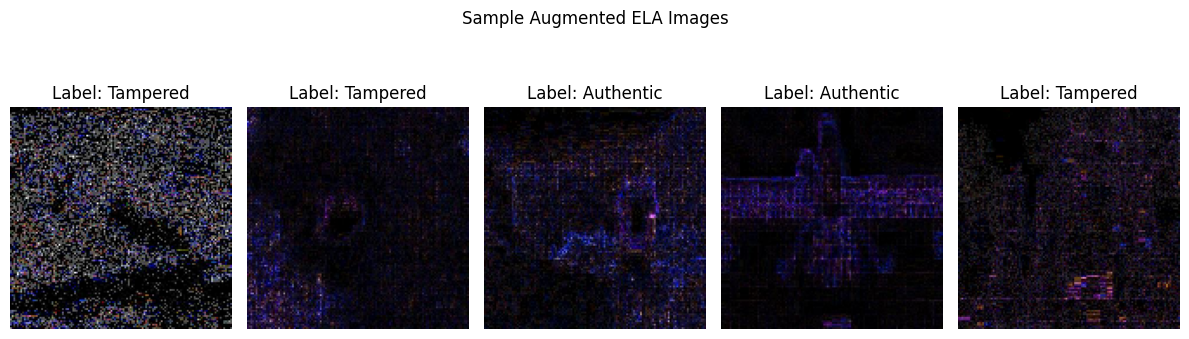

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

def create_data_generators(train_dir, val_dir, test_dir, image_size=(128, 128), batch_size=32, preview_augmented=False):
    """
    Creates training, validation, and test data generators with ELA-safe augmentations for training.
    
    Args:
        train_dir (str): Path to training images
        val_dir (str): Path to validation images
        test_dir (str): Path to test images
        image_size (tuple): Target image size
        batch_size (int): Batch size for generators
        preview_augmented (bool): If True, shows sample augmented images

    Returns:
        train_generator, val_generator, test_generator
    """

    # ELA-safe augmentations
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        #zoom_range=0.05,
        #width_shift_range=0.05,
        #height_shift_range=0.05,
        #fill_mode='nearest'
        #horizontal_flip=True
    )

    val_test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='binary'
    )

    val_generator = val_test_datagen.flow_from_directory(
        val_dir,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='binary'
    )

    test_generator = val_test_datagen.flow_from_directory(
        test_dir,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False
    )

    # Preview a few augmented ELA samples
    if preview_augmented:
        print("🔍 Previewing augmented ELA samples from training set...")
        batch = next(train_generator)
        images, labels = batch[0], batch[1]
        plt.figure(figsize=(12, 4))
        for i in range(min(5, len(images))):
            plt.subplot(1, 5, i + 1)
            plt.imshow(images[i])
            plt.title(f"Label: {'Tampered' if labels[i] == 0 else 'Authentic'}")
            plt.axis("off")
        plt.suptitle("Sample Augmented ELA Images")
        plt.tight_layout()
        plt.show()

    return train_generator, val_generator, test_generator


Train_Generator, Validation_Generator, Test_Generator = create_data_generators(
    train_dir="/home/suren/LJMU/Dataset/Casia-v2-Modified/ela_images_P/Train/",
    val_dir="/home/suren/LJMU/Dataset/Casia-v2-Modified/ela_images_P/Val/",
    test_dir="/home/suren/LJMU/Dataset/Casia-v2-Modified/ela_images_P/Test/",
    image_size=(128, 128),
    batch_size=32,
    preview_augmented=True
)


In [9]:

def train_and_evaluate_model(model, Train_Generator, Validation_Generator, Test_Generator, epochs=30, patience=5):
    import time
    import matplotlib.pyplot as plt
    from tensorflow.keras.callbacks import EarlyStopping
    import matplotlib.pyplot as plt
    from tensorflow.keras.callbacks import EarlyStopping
    from tensorflow.keras.callbacks import ReduceLROnPlateau
    """
    This function trains the model with early stopping, plots the training history, 
    and evaluates the model on the test set.
    
    Args:
    - model: The compiled model to train.
    - Train_Generator: Training data generator.
    - Validation_Generator: Validation data generator.
    - Test_Generator: Test data generator.
    - epochs: Number of epochs to train (default is 30).
    - patience: Number of epochs with no improvement to stop training early (default is 5).
    
    Returns:
    - test_loss: Loss on the test set.
    - test_accuracy: Accuracy on the test set.
    """
    
    # Step 1: Define Early Stopping callback
    Early_Stop = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
   

    lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=1e-6)
    # Step 2: Train the model with the generators
    History = model.fit(
        Train_Generator,
        validation_data=Validation_Generator,
        epochs=epochs,
        #steps_per_epoch=Train_Generator.samples // Train_Generator.batch_size,
        #validation_steps=Validation_Generator.samples // Validation_Generator.batch_size,
        callbacks=[Early_Stop,lr_reduction]
    )

    time.sleep(5)

    # Step 3: Plot the training history (accuracy and loss)
    plt.figure(figsize=(14, 5))
    
    # Plot training & validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(History.history['accuracy'], label='Training Accuracy')
    plt.plot(History.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training & validation loss
    plt.subplot(1, 2, 2)
    plt.plot(History.history['loss'], label='Training Loss')
    plt.plot(History.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

    # Step 4: Evaluate the model on the test set
    test_loss, test_accuracy = model.evaluate(Test_Generator)
    
    # Print the test accuracy
    print(f"\nTest Accuracy: {test_accuracy:.4f}")
    
    return test_loss, test_accuracy


from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [10]:
def evaluate_model_performance_dynamic_threshold(model, Test_Generator, Class_Names=['Tampered', 'Authentic']):
    import numpy as np
    import seaborn as sns
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

    # Step 1: Get prediction probabilities
    y_probs = model.predict(Test_Generator, steps=Test_Generator.samples // Test_Generator.batch_size + 1).flatten()
    y_true = Test_Generator.classes

    # Align length
    min_len = min(len(y_probs), len(y_true))
    y_probs = y_probs[:min_len]
    y_true = y_true[:min_len]

    # Step 2: Search for the best threshold based on F1-score
    thresholds = np.linspace(0.01, 0.99, 99)
    f1_scores = []

    for threshold in thresholds:
        y_pred = (y_probs >= threshold).astype(int)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        f1_scores.append(f1)

    best_index = np.argmax(f1_scores)
    best_threshold = thresholds[best_index]

    # Step 3: Apply best threshold
    final_predictions = (y_probs >= best_threshold).astype(int)
    Conf_Matrix = confusion_matrix(y_true, final_predictions)

    # Step 4: Plot confusion matrix
    plt.figure(figsize=(6, 6))
    sns.heatmap(Conf_Matrix, annot=True, fmt='d', cmap='Blues', xticklabels=Class_Names, yticklabels=Class_Names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix (Threshold = {best_threshold:.2f})')
    plt.show()

    # Step 5: Metrics
    Precision = precision_score(y_true, final_predictions)
    Recall = recall_score(y_true, final_predictions)
    F1 = f1_score(y_true, final_predictions)
    Accuracy = accuracy_score(y_true, final_predictions)

    # Step 6: Plot F1-score vs Threshold
    plt.figure(figsize=(8, 5))
    plt.plot(thresholds, f1_scores, marker='o', linestyle='-', color='purple')
    plt.axvline(best_threshold, color='red', linestyle='--', label=f'Best Threshold = {best_threshold:.2f}')
    plt.xlabel('Threshold')
    plt.ylabel('F1-Score')
    plt.title('F1-Score vs Threshold')
    plt.grid(True)
    plt.legend()
    plt.show()
    
    # Print everything
    print(f'✅ Optimal Threshold: {best_threshold:.2f}')
    print(f'Accuracy: {Accuracy:.4f}')
    print(f'Precision: {Precision:.4f}')
    print(f'Recall: {Recall:.4f}')
    print(f'F1-score: {F1:.4f}')

    return Conf_Matrix, Precision, Recall, F1, Accuracy, best_threshold


In [11]:
import pandas as pd
import os
from datetime import datetime

def log_model_run(csv_path, model_name,
                  Var_Quality, Var_Contrast, Var_Brightness, Var_Sharpness,
                  Var_inversion, Var_Clahe, Var_BlueChannel,
                  Var_Epochs, Var_Patience,
                  precision, recall, f1, accuracy, best_threshold):
    """
    Logs a single model run to CSV and auto-generates model name if not provided.

    Args:
        csv_path (str): Path to the CSV file.
        model_name (str or None): If None, a model name will be generated from parameters.
        Var_Quality, Var_Contrast, ..., best_threshold: Parameters and metrics.
    """

    # Auto-generate model name if not provided
    if not model_name:
        model_name = f"MobileNetV2_C{Var_Contrast}_B{Var_Brightness}_S{Var_Sharpness}" \
                     f"_CLAHE{int(Var_Clahe)}_INV{int(Var_inversion)}_BC{int(Var_BlueChannel)}_E{Var_Epochs}"

    log_entry = {
        "Timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "Model_Name": model_name,
        "ELA_Quality": Var_Quality,
        "ELA_Contrast": Var_Contrast,
        "ELA_Brightness": Var_Brightness,
        "ELA_Sharpness": Var_Sharpness,
        "ELA_Inversion": Var_inversion,
        "ELA_CLAHE": Var_Clahe,
        "ELA_BlueChannel": Var_BlueChannel,
        "Epochs": Var_Epochs,
        "Patience": Var_Patience,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1_Score": f1,
        "Best_Threshold": best_threshold
    }

    df_entry = pd.DataFrame([log_entry])

    if os.path.exists(csv_path):
        df_entry.to_csv(csv_path, mode='a', header=False, index=False)
    else:
        df_entry.to_csv(csv_path, mode='w', header=True, index=False)

    print(f"✅ Model run logged to {csv_path} as '{model_name}'")
    return log_entry


In [ ]:
from tensorflow.keras.applications import MobileNetV2  
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.activations import swish

import time


base_model_3 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
x = base_model_3.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation=swish)(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model_3.input, outputs=predictions)

# Freeze base model layers if you want to fine-tune later
for layer in base_model_3.layers[-15:]:
    layer.trainable = True

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Var_Epochs = 30
Var_Patience = 5

test_loss, test_accuracy = train_and_evaluate_model(
    model, 
    Train_Generator, 
    Validation_Generator, 
    Test_Generator, 
    epochs=Var_Epochs, 
    patience=Var_Patience
)

confusion_matrix, precision, recall, f1, accuracy,best_threshold = evaluate_model_performance_dynamic_threshold(model, Test_Generator)

log_model_run(
    csv_path="/home/suren/LJMU/CodeBase/StableVersions-MobileNet/ProcessedImageForensics/P_model_results_log.csv",
    model_name=None,
    Var_Quality=Var_Quality,
    Var_Contrast=Var_Contrast,
    Var_Brightness=Var_Brightness,
    Var_Sharpness=Var_Sharpness,
    Var_inversion=Var_inversion,
    Var_Clahe=Var_Clahe,
    Var_BlueChannel=Var_BlueChannel,
    Var_Epochs=Var_Epochs,
    Var_Patience=Var_Patience,
    precision=precision,
    recall=recall,
    f1=f1,
    accuracy=accuracy,
    best_threshold=best_threshold
)


I0000 00:00:1754312230.008790   81697 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5592 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6


Epoch 1/30


/home/suren/miniconda3/envs/tf-gpu/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1754312243.967032   82034 service.cc:152] XLA service 0x7bcbb8004b30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754312243.967106   82034 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
I0000 00:00:1754312247.029793   82034 cuda_dnn.cc:529] Loaded cuDNN version 90300


  5/238 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.6558 - loss: 0.7026   

I0000 00:00:1754312263.004417   82034 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


238/238 ━━━━━━━━━━━━━━━━━━━━ 61s 123ms/step - accuracy: 0.8782 - loss: 0.3769 - val_accuracy: 0.2116 - val_loss: 7.5598 - learning_rate: 0.0010
Epoch 2/30
238/238 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.9268 - loss: 0.1950 - val_accuracy: 0.5242 - val_loss: 6.7186 - learning_rate: 0.0010
Epoch 3/30
238/238 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.9478 - loss: 0.1576 - val_accuracy: 0.8274 - val_loss: 0.5949 - learning_rate: 0.0010
Epoch 4/30
238/238 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.9407 - loss: 0.1624 - val_accuracy: 0.6505 - val_loss: 0.5407 - learning_rate: 0.0010
Epoch 5/30
238/238 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - accuracy: 0.9543 - loss: 0.1260 - val_accuracy: 0.8347 - val_loss: 0.9871 - learning_rate: 0.0010
Epoch 6/30
  7/238 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.9696 - loss: 0.0676